# PGVnet: Predicting Peak Ground Velocity (PGV) Maps

**Purpose.** Demonstrate a two-step framework to predict spatially-continuous PGV maps:
1) Train receiver-specific XGBoost predictors to generate a sparsely-sampled PGV.
2) Train an encoder–MLP network to finetune PGV maps from sparse inputs.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pgvnet import train_xgb, generate_sparse_pgv, run_train
from pgvnet.encoderMLP_predictor import run_test
import os, yaml 
from types import SimpleNamespace

## Step 1 — Train Receiver-Specific XGBoost Models

We fit one XGBoost regressor **per receiver** to map source parameters → `log(PGV)`.  
This cell demonstrates a single receiver; training for all receivers is done offline and saved to `XGBmodels/`.

Training R²: 0.9302
Test R²: 0.8886


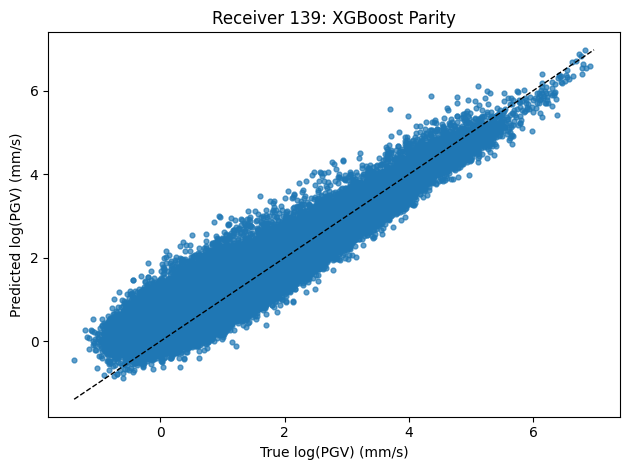

In [2]:
# Pick one receiver for demonstration (0–255 typical)
receiver_idx = 139
db_path = f"data/reciprocal_db/receiver_{receiver_idx}_database.npz"
assert os.path.exists(db_path), f"Missing: {db_path}"

rec_db = np.load(db_path)
X = rec_db["inputs"]            # [distance, azimuth, depth, strike, dip, rake, radiation, takeoff]
y = np.log(rec_db["outputs"][:, 0])  # log(PGV) for East–West component

y_true, y_pred = train_xgb(X, y)

# Parity plot
fig, ax = plt.subplots()
ax.scatter(y_true, y_pred, s=12, alpha=0.7)
low, high = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
ax.plot([low, high], [low, high], linestyle="--", linewidth=1, color="k")
ax.set_xlabel("True log(PGV) (mm/s)")
ax.set_ylabel("Predicted log(PGV) (mm/s)")
ax.set_title(f"Receiver {receiver_idx}: XGBoost Parity")
plt.tight_layout()
plt.show()


### Generate Sparse PGV Maps

Using the trained per-receiver models, we generate sparse PGV fields for a set of sources/mechanisms.  
These serve as inputs to the encoder–decoder in Step 2.


Predicting Sparse PGV Maps for 500 events: 100%|██████████| 256/256 [04:10<00:00,  1.02it/s]

Saved sparse PGV map to data/step1_preds/step1_preds_10_50_x4.npz


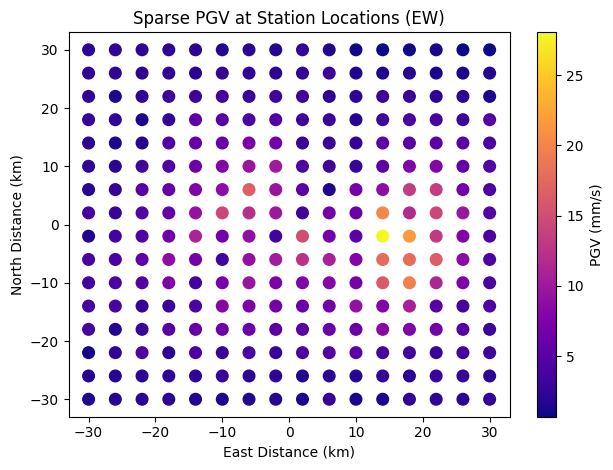

In [3]:
# Example tags/paths (adjust to your setup)
data_tag   = "10_50"
models_dir = "/media/wolf6819/Elements/PGVnet/data/xgb_models"
spacing_km = 4
station_coords_path = "/media/wolf6819/Elements/PGVnet/data/receiver_coords_sparse.npz"
output_path = "data/step1_preds"

# Generate sparse PGV maps
sparse_maps = generate_sparse_pgv(station_coords_path, models_dir, output_path, data_tag, spacing_km)

# Visualize one sparse map at station locations (EW component = [:,:,0])
coords = np.load(station_coords_path)["station_coords"]
fig, ax = plt.subplots()
sc = ax.scatter(coords[:, 0] / 1e3, coords[:, 1] / 1e3,
                c=sparse_maps[0, :, :, 0], s=70, cmap="plasma")
ax.set_xlabel("East Distance (km)")
ax.set_ylabel("North Distance (km)")
ax.set_title("Sparse PGV at Station Locations (EW)")
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("PGV (mm/s)")
plt.tight_layout()
plt.show()


## Step 2 — Train Encoder–Decoder on Sparse Inputs

We fit an encoder–decoder to reconstruct dense PGV maps from the sparse station inputs.  
The configuration below is explicit and minimal; tune as required for your data.

In [4]:
from dataclasses import dataclass

@dataclass
class Config:
    mode: str = "train"
    data_tag: str = "10_50_x4"
    downsample_factor: int = 4
    data_dir: str = "data/"
    transform_input: bool = True
    transform_output: bool = True
    inc_gradient: bool = False
    inc_distance: bool = True
    normalize_output: bool = True
    normalize_input: bool = True
    nx_patch: int = 8
    ny_patch: int = 8
    fourier_features: bool = False
    D: int = 32
    gamma: float = 5.0
    n_samp_pts_per_patch: int = 512
    split: float = 0.8
    batch_size: int = 32
    learning_rate: float = 1e-3
    loss_type: str = "mse"
    optimizer: str = "adamw"
    num_epochs: int = 1
    enc_type: str = "edsr"
    in_channels: int = 5
    out_channels: int = 32
    conv_kernel_size: int = 3
    attention_kernel_size: int = 1
    num_features: int = 32
    num_blocks: int = 8
    nf: int = 32
    activation: str = "leaky_relu"
    pad_size: int = 4
    sigma: float = 3.0
    results_dir: str = None
    stats_tag: str = "10_50_x4"

config = Config()
run_train(config)


[MASTER] run_id=20251019_204351_a3c650 | seed=20251005
[Run 0] test=50 (10%) | train=450 | dir=./results/20251019_204351_a3c650/20251019_204351_a3c650_run0_p10
Number of patches: 7200


Training Epochs: 100%|██████████| 1/1 [00:22<00:00, 22.13s/it]


Epoch 0: Train Loss 0.3347 | Valid Loss 0.2742
Configuration saved to ./results/20251019_204351_a3c650/20251019_204351_a3c650_run0_p10/config.yaml.
[Run 1] test=50 (10%) | train=450 | dir=./results/20251019_204351_a3c650/20251019_204351_a3c650_run1_p10
Number of patches: 7200


Training Epochs: 100%|██████████| 1/1 [00:21<00:00, 21.86s/it]


Epoch 0: Train Loss 0.3468 | Valid Loss 0.2744
Configuration saved to ./results/20251019_204351_a3c650/20251019_204351_a3c650_run1_p10/config.yaml.
[Run 2] test=50 (10%) | train=450 | dir=./results/20251019_204351_a3c650/20251019_204351_a3c650_run2_p10
Number of patches: 7200


Training Epochs: 100%|██████████| 1/1 [00:21<00:00, 21.62s/it]

Epoch 0: Train Loss 0.3438 | Valid Loss 0.2819
Configuration saved to ./results/20251019_204351_a3c650/20251019_204351_a3c650_run2_p10/config.yaml.
All runs complete.


## Evaluation on Held-Out Events

We reuse the training configuration saved to `results/test_hold0/config.yaml` for reproducibility.
We only override two fields for inference:

- `mode = "test"`
- `results_dir = "results/test_hold0"`

This runs evaluation on the held-out split and writes `test_preds.npy` and `test_gts.npy` into the results folder.


In [6]:
cfg_path = "results/20251019_204351_a3c650/20251019_204351_a3c650_run2_p10/config.yaml"
assert os.path.exists(cfg_path), f"Config not found: {cfg_path}"

with open(cfg_path, "r") as f:
    cfg_dict = yaml.safe_load(f)

config = SimpleNamespace(**cfg_dict)
config.mode = "test"
config.results_dir = "results/20251019_204351_a3c650/20251019_204351_a3c650_run2_p10"

# Run testing (expected to save test_preds.npy / test_gts.npy under results_dir)
run_test(config)

Testing using results from: results/20251019_204351_a3c650/20251019_204351_a3c650_run2_p10


Reconstructing patches For Test Maps: 100%|██████████| 1250/1250 [00:05<00:00, 228.11it/s]


Test SSIM: 0.5829


We compare predicted vs. true PGV maps on the test split

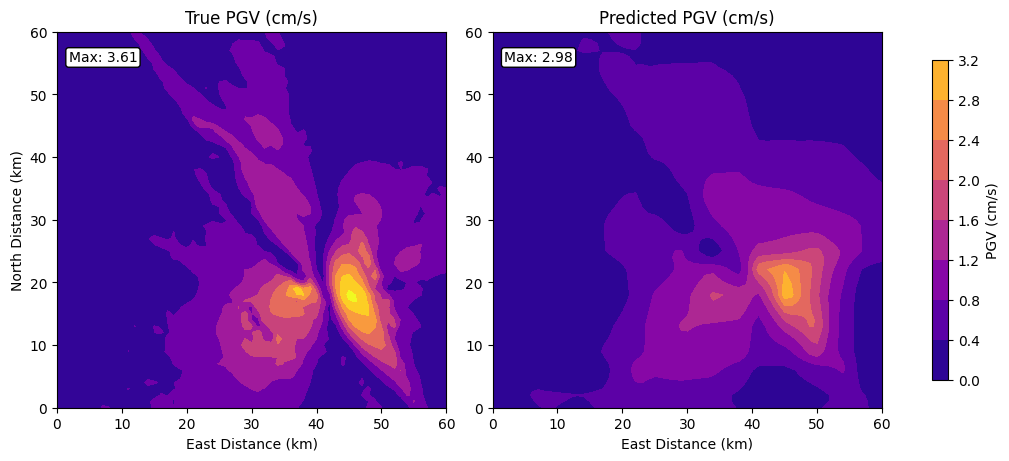

In [8]:
preds = np.load("results/20251019_204351_a3c650/20251019_204351_a3c650_run2_p10/test_preds.npy")
gts   = np.load("results/20251019_204351_a3c650/20251019_204351_a3c650_run2_p10/test_gts.npy")

idx  = np.random.randint(0, preds.shape[0])   # random test example
comp = 1  # 0: East–West, 1: North–South

pred = preds[idx, :, :, comp] / 10.0  # cm/s
gt   = gts[idx, :, :, comp] / 10.0    # cm/s

vmax = max(np.max(gt), np.max(pred))
norm = plt.Normalize(vmin=0, vmax=vmax)

fig, axes = plt.subplots(1, 2, figsize=(10, 4.5), constrained_layout=True)
cf0 = axes[0].contourf(gt, cmap="plasma", norm=norm)
cf1 = axes[1].contourf(pred, cmap="plasma", norm=norm)

axes[0].set_title("True PGV (cm/s)")
axes[1].set_title("Predicted PGV (cm/s)")
for ax in axes:
    ax.set_xlabel("East Distance (km)")
axes[0].set_ylabel("North Distance (km)")

cbar = fig.colorbar(cf1, ax=axes.ravel().tolist(), shrink=0.85)
cbar.set_label("PGV (cm/s)")

axes[0].text(0.03, 0.95, f"Max: {np.max(gt):.2f}",
             transform=axes[0].transAxes, va="top",
             bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"))
axes[1].text(0.03, 0.95, f"Max: {np.max(pred):.2f}",
             transform=axes[1].transAxes, va="top",
             bbox=dict(facecolor="white", edgecolor="black", boxstyle="round,pad=0.2"))
plt.show()
